# Enhanced Changeover Detection in Industry 4.0 environments with Machine Learning

This notebook contains all the preliminary models used in the OBerA project.
It belongs to the article "Enhanced Changeover Detection in Industry 4.0 Environments with Machine Learning" which can be found in Open Access by the following link: <https://www.mdpi.com/1424-8220/21/17/5896/htm>


## ⚠️ <span style="color:red">**Before you hit *"Run All"* be advised that it will also run SVC which will take more than 15 minutes to run. If this is something you want to avoid, we have some static variables as outputs of SVC prepared.**</span> ⚠️

## <span style="color:yellow">**You might encounter a *"ValueError: object of too small depth for desired array"* when running Balanced Random Forest if your Python version is *lower* than 3.8**</span>

## Packages used

Except for imblearn other packages used here are rather common for Anaconda distribution. Most of them are of the newest (or rather new) versions as of August 2021. You shall be able replicate the same results with the newest versions of these packages. However, below the version list of the packages used in the imports will be presented.

*For those interested, a 'requirements.txt' (generated by conda) file with all the packages used within the environment was also added to the project*


conda version : 4.10.3

python version : 3.9.6


pandas==1.3.2

numpy==1.21.2

matplotlib==3.4.3

seaborn==0.11.2

tensorflow==2.6.0

scikit-learn==0.24.2

imbalanced-learn==0.8.0


# Imports


In [1]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib as mpl #for visualization
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import tensorflow as tf #for neural networks
from tensorflow import keras #for neural networks

# Metrics
from sklearn import metrics #metrics
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models
from sklearn.tree import DecisionTreeClassifier #basic decision tree
from tensorflow.keras.optimizers import Adam #optimizer for neural networks
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest classifier
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import ExtraTreesClassifier #extra trees classifier
from sklearn.svm import SVC #support vector machine linear classifier

# Function definition

Here we define a few functions that will be used to evaluate the models.


## Confusion matrix function


In [2]:
# Define the confusion matrix function with graphical output

def cf_matrix(test_labels, y_pred):

      # Create a basic confusion matrix
      cf = confusion_matrix(test_labels, y_pred)

      # Configuration of a confusion matrix
      group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
      group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

      # Labeling
      labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
      labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
      labels = np.asarray(labels).reshape(2,2)

      # Plotting 
      sns.heatmap(cf, annot=labels, fmt='', cmap='Blues',)
      plt.title('Confusion-Matrix', fontsize = 20) #title with fontsize 20
      plt.xlabel('Predicted Label', fontsize = 15) #x-axis label with fontsize 15
      plt.ylabel('True Label', fontsize = 15) #y-axis label with fontsize 15

      # Assigning correct labels and their position
      ax = plt.gca()
      ax.set_xticklabels(['Changeover', 'Production'])
      ax.set_yticklabels(['Changeover', 'Production'], va='center')

      # Displaying
      print(cf_matrix)

## ROC curve function
 

In [32]:
# Define the ROC curve function with graphical output

def plot_roc_curve(model):

    #setting up the parameters
    try:
        probs = model.predict(test_features)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
    except ValueError: #this is needed for Neural Network
        probs = np.argmax(model.predict(test_features, batch_size=1, verbose=0), axis=-1)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
        
    #plotting the ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #print AUC score
    print(f"AUC score: {roc_auc_score(test_labels, probs)}")

In [4]:
# Import data from csv
df = pd.read_csv('Data from 31.03.2021 with Labels Outer Join.csv', delimiter=',', index_col=0,) #Data from 31.03.2021 with Labels.csv
df.head() #show first 5 entries

,DateTime,Distance,Power,Liter,V1,V2,X,Y,Phase,Phase_compressed,Production
28,2021-03-31 06:58:28,1.0,3278.437,0.0,0.0,0.0,1.206000,1.142373,1,1,0
29,2021-03-31 06:58:29,1.0,3292.477,0.0,0.0,0.0,1.346650,1.052089,1,1,0
30,2021-03-31 06:58:30,1.0,3289.743,0.0,0.0,0.0,1.406439,0.724651,1,1,0
31,2021-03-31 06:58:30,1.0,3289.743,0.0,0.0,0.0,1.406439,0.551185,1,1,0
32,2021-03-31 06:58:30,1.0,3289.743,0.0,0.0,0.0,1.433358,0.724651,1,1,0


# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [5]:
# Dropping the columns we do not need
df.drop(['DateTime', 'Phase', 'Phase_compressed'], axis=1, inplace=True)
df.head() #show first 5 entries

,Distance,Power,Liter,V1,V2,X,Y,Production
28,1.0,3278.437,0.0,0.0,0.0,1.206000,1.142373,0
29,1.0,3292.477,0.0,0.0,0.0,1.346650,1.052089,0
30,1.0,3289.743,0.0,0.0,0.0,1.406439,0.724651,0
31,1.0,3289.743,0.0,0.0,0.0,1.406439,0.551185,0
32,1.0,3289.743,0.0,0.0,0.0,1.433358,0.724651,0


# Data description


In [6]:
# Using the describe function to get 'raw' insights
df.describe()

,Distance,Power,Liter,V1,V2,X,Y,Production
count,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000
mean,0.987144,941.545698,9.170771,0.528782,0.793968,2.993836,1.131005,0.349019
std,0.112657,2426.354646,22.060219,0.499177,0.404459,1.347984,0.669302,0.476666
min,0.000000,-31337.590000,0.000000,0.000000,0.000000,-0.097020,-0.035480,0.000000
25%,1.000000,-328.850000,0.000000,0.000000,1.000000,2.312167,0.777261,0.000000
50%,1.000000,1558.843000,0.000000,1.000000,1.000000,3.523018,1.024344,0.000000
75%,1.000000,2948.010000,0.000000,1.000000,1.000000,3.901250,1.554425,1.000000
max,1.000000,19332.470000,74.000000,1.000000,1.000000,15.642741,13.604223,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

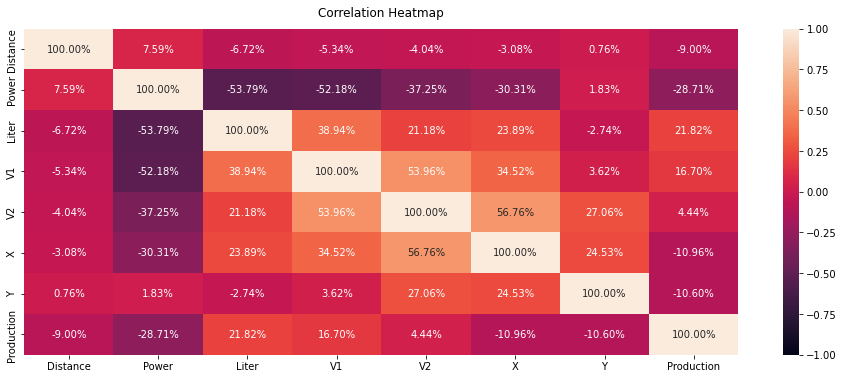

In [7]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [8]:
# Splitting the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df.pop('Production'))
test_labels = np.array(test_df.pop('Production'))
train_features = np.array(train_df)
test_features = np.array(test_df)

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Having a look at the results
print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (31672,)
Test labels shape: (7919,)
Training features shape: (31672, 7)
Test features shape: (7919, 7)


# Decision Tree


In [15]:
# Create a Decision Tree classifier object
clf_DT = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf_DT = clf_DT.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_DT = clf_DT.predict(test_features)

In [16]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_DT))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5148
           1       0.94      0.94      0.94      2771

    accuracy                           0.96      7919
   macro avg       0.95      0.95      0.95      7919
weighted avg       0.96      0.96      0.96      7919



In [17]:
# Get macro average F1 score
f1_DT = f1_score(test_labels, y_pred_DT, average='macro')
f1_DT

0.9523297792664269

In [18]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_DT = matthews_corrcoef(test_labels, y_pred_DT)
MCC_DT

0.9046701421177795

<function cf_matrix at 0x000001BDDDED1280>


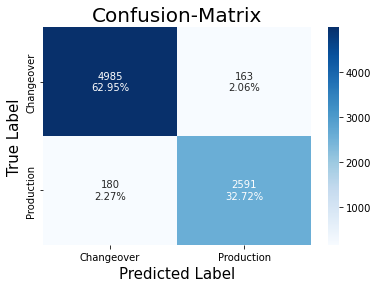

In [19]:
# Plot the confusion matrix for the Decision Tree
cf_matrix(test_labels,y_pred_DT)

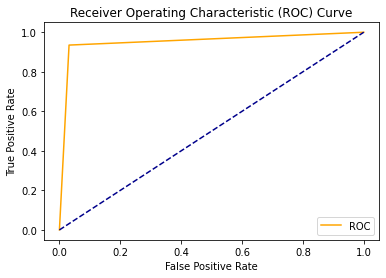

AUC score: 0.9516893598001501


In [33]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_DT)

# Neural Network


In [21]:
# Create neural network object
clf_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100,activation='relu',input_shape=(7,)),
    tf.keras.layers.Dropout(0.1), #prevention of overfitting
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
    ])

# Set up and train neural network
opt = keras.optimizers.Adam(learning_rate=0.01)
clf_NN.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = clf_NN.fit(train_features,train_labels, epochs=50, batch_size=50,validation_data=(test_features, test_labels))
clf_NN.evaluate(test_features, test_labels)

# Predict the response for the test dataset
y_pred_NN = clf_NN.predict(test_features,batch_size=1,verbose=0)

weights = clf_NN.get_weights() #returns a numpy list of weights

Epoch 1/50
634/634 [==============================] - 1s 1ms/step - loss: 0.4710 - accuracy: 0.7745 - val_loss: 0.4315 - val_accuracy: 0.7901
Epoch 2/50
634/634 [==============================] - 1s 1ms/step - loss: 0.4161 - accuracy: 0.7962 - val_loss: 0.3881 - val_accuracy: 0.8001
Epoch 3/50
634/634 [==============================] - 1s 1ms/step - loss: 0.3876 - accuracy: 0.8117 - val_loss: 0.3945 - val_accuracy: 0.8247
Epoch 4/50
634/634 [==============================] - 1s 1ms/step - loss: 0.3760 - accuracy: 0.8233 - val_loss: 0.3539 - val_accuracy: 0.8355
Epoch 5/50
634/634 [==============================] - 1s 1ms/step - loss: 0.3600 - accuracy: 0.8302 - val_loss: 0.3381 - val_accuracy: 0.8478
Epoch 6/50
634/634 [==============================] - 1s 1ms/step - loss: 0.3523 - accuracy: 0.8357 - val_loss: 0.3359 - val_accuracy: 0.8423
Epoch 7/50
634/634 [==============================] - 1s 1ms/step - loss: 0.3528 - accuracy: 0.8352 - val_loss: 0.3169 - val_accuracy: 0.8538
Epoch 

In [22]:
# Predicted values as integers
y_pred_NN = np.argmax(clf_NN.predict(test_features, batch_size=1, verbose=0), axis=-1)
print(y_pred_NN)

[0 0 0 ... 0 1 0]


In [23]:
# Get the metrics for the Neural Network
print(classification_report(test_labels,y_pred_NN))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      5148
           1       0.86      0.80      0.83      2771

    accuracy                           0.88      7919
   macro avg       0.88      0.86      0.87      7919
weighted avg       0.88      0.88      0.88      7919



In [24]:
# Get macro average F1 score
f1_NN = f1_score(test_labels, y_pred_NN, average='macro')
f1_NN

0.870230256384607

In [35]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_NN = matthews_corrcoef(test_labels, y_pred_NN)
MCC_NN

0.7416407827369598

<function cf_matrix at 0x000001BDDDED1280>


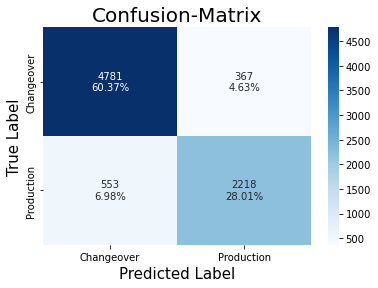

In [26]:
# Plot the confusion matrix for the Neural Network
cf_matrix(test_labels,y_pred_NN)

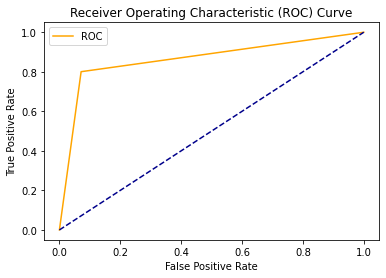

AUC score: 0.8645716176842123


In [34]:
# Plot the ROC curve and get the AUC score for the Neural Network
plot_roc_curve(clf_NN)

# Balanced Random Forest


In [36]:
# Create a Balanced Random Forest classifier object
clf_BRF = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Train the Balanced Random Forest Classifier
clf_BRF = clf_BRF.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_BRF = clf_BRF.predict(test_features)

In [37]:
# Get the metrics for the Balanced Random Forest
print(classification_report(test_labels,y_pred_BRF))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5148
           1       0.95      0.96      0.96      2771

    accuracy                           0.97      7919
   macro avg       0.96      0.97      0.97      7919
weighted avg       0.97      0.97      0.97      7919



In [38]:
# Get macro average F1 score
f1_BRF = f1_score(test_labels, y_pred_BRF, average='macro')
f1_BRF

0.9654635653916577

In [39]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_BRF = matthews_corrcoef(test_labels, y_pred_BRF)
MCC_BRF

0.9310423462283628

<function cf_matrix at 0x000001BDDDED1280>


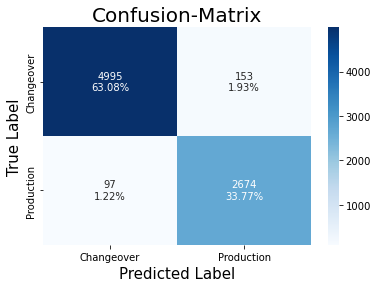

In [40]:
# Plot the confusion matrix for the Balanced Random Forest
cf_matrix(test_labels,y_pred_BRF)

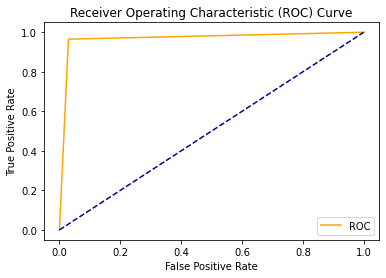

AUC score: 0.9676371535357462


In [41]:
# Plot the ROC curve and get the AUC score for the Balanced Random Forest
plot_roc_curve(clf_BRF)

# Random Forest


In [42]:
# Create a Random Forest classifier object with best parameters found via grid search
clf_RF = RandomForestClassifier(n_estimators=48, bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=2, random_state=0)

# Train the Random Forest Classifier
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_RF = clf_RF.predict(test_features)

In [43]:
# Get the metrics for the Random Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5148
           1       0.97      0.95      0.96      2771

    accuracy                           0.98      7919
   macro avg       0.97      0.97      0.97      7919
weighted avg       0.98      0.98      0.98      7919



In [44]:
# Get macro average F1 score
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.9725230691977741

In [45]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.9451775126239347

<function cf_matrix at 0x000001BDDDED1280>


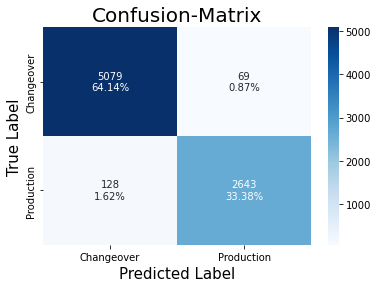

In [46]:
# Plot the confusion matrix for the Random Forest
cf_matrix(test_labels,y_pred_RF)

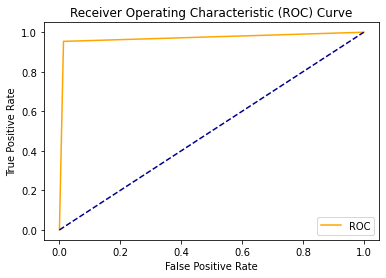

AUC score: 0.9702020131919086


In [47]:
# Plot the ROC curve and get the AUC score for the Random Forest
plot_roc_curve(clf_RF)

# Extra trees

*Additional model that is not featured in the article. However, it looks very promising and is likely to be considered in the future research.*


In [48]:
# Create an Extra Trees classifier object
clf_ET = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, max_features=1)

# Train Extra Trees Classifier
clf_ET = clf_ET.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_ET = clf_ET.predict(test_features)

In [49]:
# Get the metrics for the Extra Trees
print(classification_report(test_labels,y_pred_ET))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5148
           1       0.98      0.95      0.96      2771

    accuracy                           0.98      7919
   macro avg       0.98      0.97      0.97      7919
weighted avg       0.98      0.98      0.98      7919



In [50]:
# Get macro average F1 score
f1_ET = f1_score(test_labels, y_pred_ET, average='macro')
f1_ET

0.9733000427879573

In [51]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_ET = matthews_corrcoef(test_labels, y_pred_ET)
MCC_ET

0.9468742360079958

<function cf_matrix at 0x000001BDDDED1280>


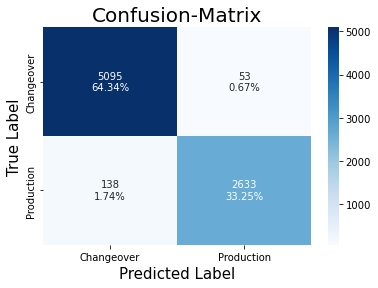

In [52]:
# Plot the confusion matrix for the Extra Trees
cf_matrix(test_labels,y_pred_ET)

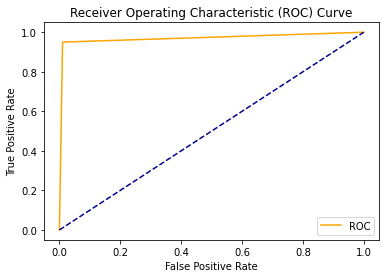

AUC score: 0.969951612003218


In [53]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_ET)

# SVC


## ⚠️ <span style="color:red">**SVC takes a lot of time to run!!! More than 15 minutes!**</span> ⚠️

<span style="color:blue">**You can use static metrics in place of calculated ones if you do not want to wait >20 minutes for the SVC to run.**</span>

We obtained those during our runs. Static metrics can be found in the end of SVC section.

In [54]:
# Create an SVC classifier object
clf_SVC = SVC(kernel='rbf', C=100000)

# Train the SVC Classifier
clf_SVC = clf_SVC.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_SVC = clf_SVC.predict(test_features)

In [55]:
# Get the metrics for the SVC
print(classification_report(test_labels,y_pred_SVC))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5148
           1       0.91      0.73      0.81      2771

    accuracy                           0.88      7919
   macro avg       0.89      0.84      0.86      7919
weighted avg       0.88      0.88      0.88      7919



In [56]:
# Get macro average F1 score
f1_SVC = f1_score(test_labels, y_pred_SVC, average='macro')
f1_SVC

0.8602850449576763

In [57]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_SVC = matthews_corrcoef(test_labels, y_pred_SVC)
MCC_SVC

0.7308375730727619

<function cf_matrix at 0x000001BDDDED1280>


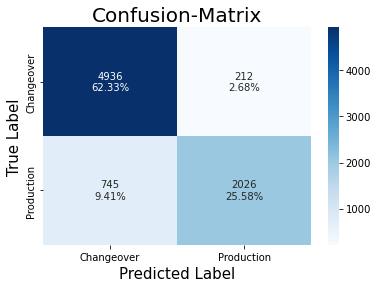

In [58]:
# Plot the confusion matrix for the SVC
cf_matrix(test_labels,y_pred_SVC)

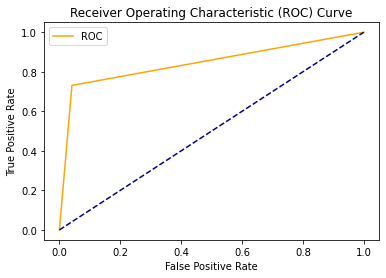

AUC score: 0.8449814750789129


In [59]:
# Plot the ROC curve and get the AUC score for the SVC
plot_roc_curve(clf_SVC)

### Static SVC metrics

In [60]:
f1_SVC_static = 0.8602850449576763

In [61]:
MCC_SVC_static = 0.7308375730727619

In [62]:
AUC_SVC_static = 0.8449814750789129

# Comparison tables

Cells below contain code to create a nice-looking table which compares F1, AUC and MCC of all algorithms used in OBerA.

<span style="color:yellow">**Please note that the table uses static values for SVC to prevent users from getting errors in case they did not run their own SVC. If you have generated your own values, please change the corresponding inputs in the following cells. If you did not modify our script, you shall simply remove "_static" from each value and it should work.**</span>

In [63]:
# Create a skeleton of the table
comp_table = pd.DataFrame(index=['Neural Network', 'SVC', 'Decision Tree', 'Balanced Random Forest', 'Random Forest', 'Extra Trees'], columns=['F1 score', 'AUC score', 'MCC'])

In [64]:
# Add values to the table
comp_table.iloc[0] = [f1_NN, roc_auc_score(test_labels, y_pred_NN), MCC_NN]
comp_table.iloc[1] = [f1_SVC_static, AUC_SVC_static, MCC_SVC_static] #if needed, put your SVC values here or simply remove "_static" from each parameter
comp_table.iloc[2] = [f1_DT, roc_auc_score(test_labels, y_pred_DT), MCC_DT]
comp_table.iloc[3] = [f1_BRF, roc_auc_score(test_labels, y_pred_BRF), MCC_BRF]
comp_table.iloc[4] = [f1_RF, roc_auc_score(test_labels, y_pred_RF), MCC_RF]
comp_table.iloc[5] = [f1_ET, roc_auc_score(test_labels, y_pred_ET), MCC_ET]

In [65]:
# Round all the values down to two digits
for i in range(len(comp_table)):
    comp_table.iloc[i] = comp_table.iloc[i].apply(lambda x: round(x, 2))

In [66]:
# Show the table
comp_table

,F1 score,AUC score,MCC
Neural Network,0.87,0.86,0.74
SVC,0.86,0.84,0.73
Decision Tree,0.95,0.95,0.9
Balanced Random Forest,0.97,0.97,0.93
Random Forest,0.97,0.97,0.95
Extra Trees,0.97,0.97,0.95


# Graphical comparison tables

Below are the graphs that compare all the models in a better, human readable way.

<span style="color:yellow">Please note that you need to run your SVC model for these graphs to work, Otherwise you could modify the code to avoid plotting SVC at all.</span>

(0.0, 1.0, 0.0, 1.0)

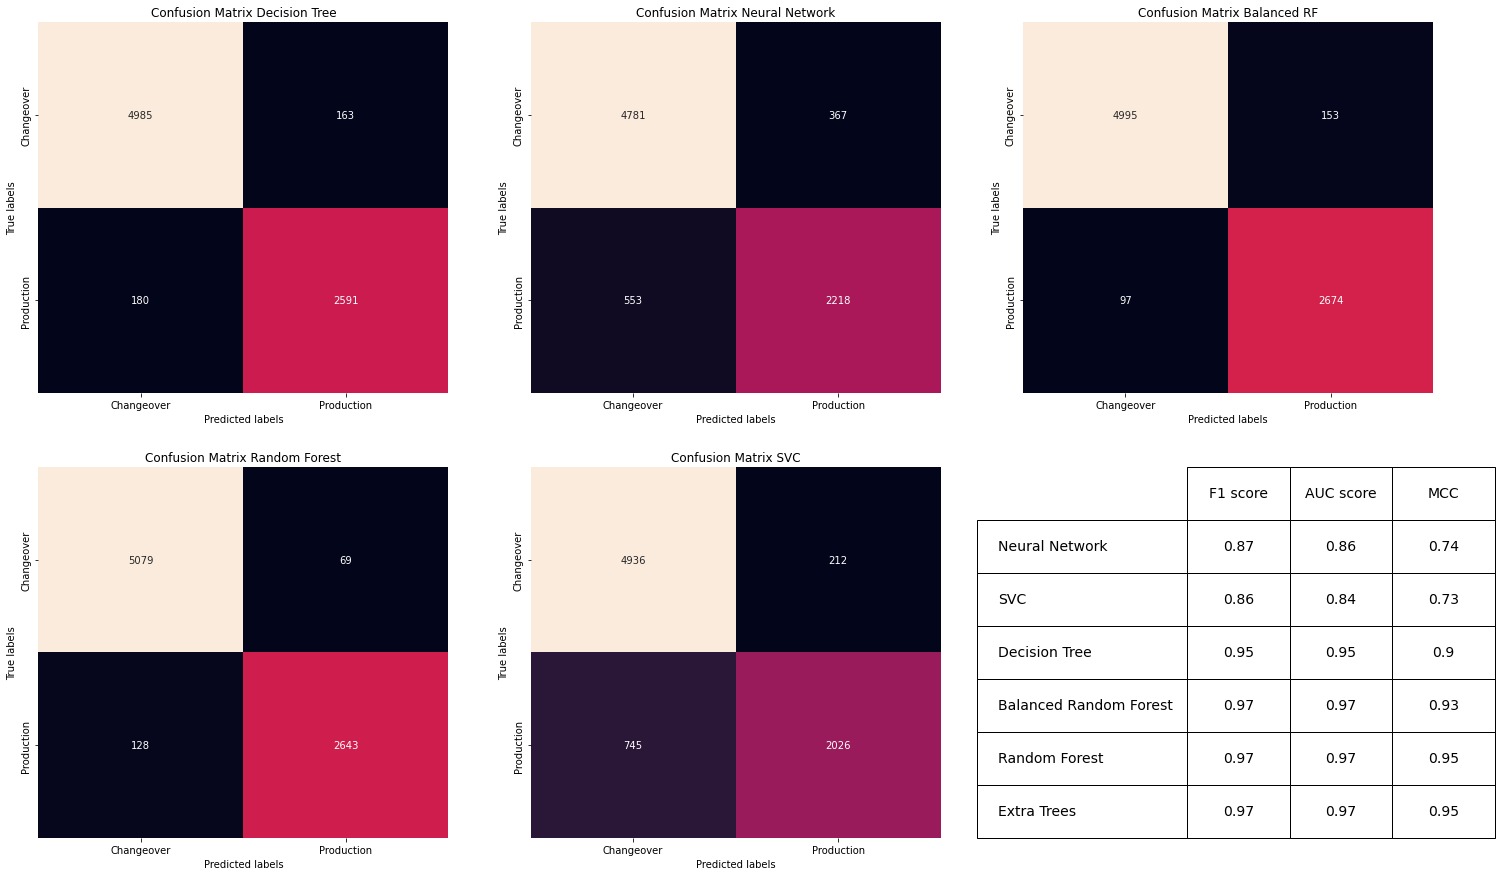

In [70]:
%%capture --no-display

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15)) #creating a skeleton of the graph

labels = ['Changeover', 'Production'] #adding labels

sns.heatmap(confusion_matrix(test_labels, y_pred_DT), cbar=False, annot=True, fmt='g', ax=axs[0,0]) #adding Decision Tree to subplot 0,0
axs[0,0].set_title('Confusion Matrix Decision Tree')

sns.heatmap(confusion_matrix(test_labels, y_pred_NN), cbar=False, annot=True, fmt='g', ax=axs[0,1]) #adding Neural Network to subplot 0,1
axs[0,1].set_title('Confusion Matrix Neural Network')

sns.heatmap(confusion_matrix(test_labels, y_pred_BRF), cbar=False, annot=True, fmt='g', ax=axs[0,2])#adding Balanced Random forest to subplot 0,2
axs[0,2].set_title('Confusion Matrix Balanced RF')

sns.heatmap(confusion_matrix(test_labels, y_pred_RF), cbar=False, annot=True, fmt='g', ax=axs[1,0])#adding Random Forest to subplot 1,0
axs[1,0].set_title('Confusion Matrix Random Forest')

sns.heatmap(confusion_matrix(test_labels, y_pred_SVC), cbar=False, annot=True, fmt='g', ax=axs[1,1])#adding SVC to subplot 1,1
axs[1,1].set_title('Confusion Matrix SVC')

for i in range(0,3): #iterating through our graphs to give a label to each
    axs[0,i].set(xlabel='Predicted labels')
    axs[0,i].set(ylabel='True labels')
    axs[0,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[0,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')
    axs[1,i].set(xlabel='Predicted labels')
    axs[1,i].set(ylabel='True labels')
    axs[1,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[1,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')

#fig.delaxes(axs[1,2]) #this line can be used to delete the unnecessary subplot from the entire plot

# Add our table with metrics from before to the graph
table = axs[1,2].table(cellText=comp_table.values,
          colLabels=comp_table.columns,
          rowLabels=comp_table.index,
          loc="lower right",
          cellLoc='center',
          bbox=[0.4, 0, 0.75, 1],
          fontsize=64).set_fontsize(14)

plt.axis('off')

Next graph is the same but includes the confusion matrix for Extra Trees model in place of the table.

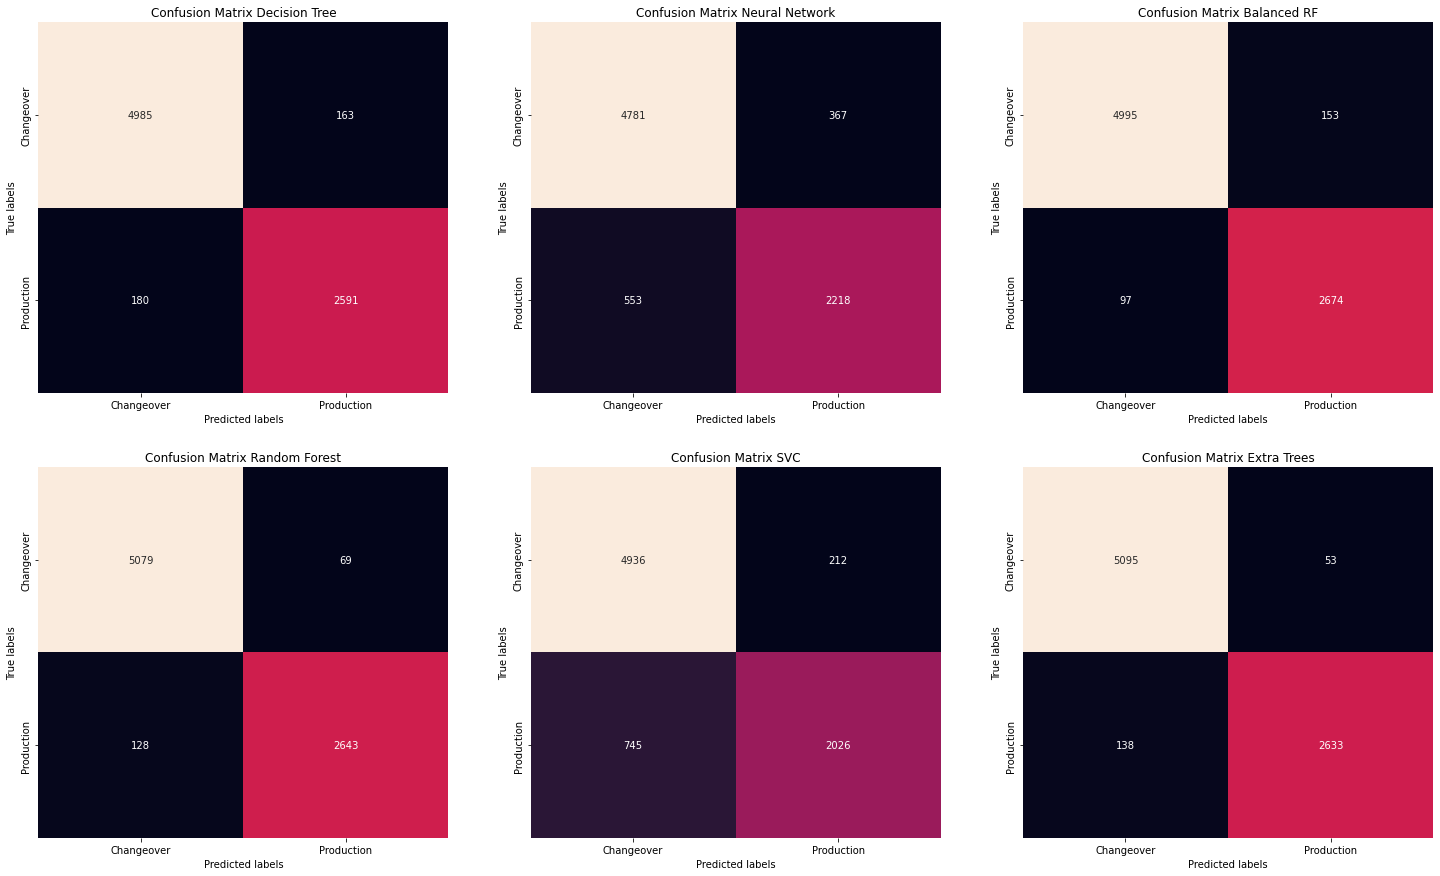

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))

labels = ['Changeover', 'Production']

sns.heatmap(confusion_matrix(test_labels, y_pred_DT), cbar=False, annot=True, fmt='g', ax=axs[0,0])
axs[0,0].set_title('Confusion Matrix Decision Tree')

sns.heatmap(confusion_matrix(test_labels, y_pred_NN), cbar=False, annot=True, fmt='g', ax=axs[0,1])
axs[0,1].set_title('Confusion Matrix Neural Network')

sns.heatmap(confusion_matrix(test_labels, y_pred_BRF), cbar=False, annot=True, fmt='g', ax=axs[0,2])
axs[0,2].set_title('Confusion Matrix Balanced RF')

sns.heatmap(confusion_matrix(test_labels, y_pred_RF), cbar=False, annot=True, fmt='g', ax=axs[1,0])
axs[1,0].set_title('Confusion Matrix Random Forest')

sns.heatmap(confusion_matrix(test_labels, y_pred_SVC), cbar=False, annot=True, fmt='g', ax=axs[1,1])
axs[1,1].set_title('Confusion Matrix SVC')

sns.heatmap(confusion_matrix(test_labels, y_pred_ET), cbar=False, annot=True, fmt='g', ax=axs[1,2])
axs[1,2].set_title('Confusion Matrix Extra Trees')

for i in range(0,3): #iterating through our graphs to give a label to each
    axs[0,i].set(xlabel='Predicted labels')
    axs[0,i].set(ylabel='True labels')
    axs[0,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[0,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')
    axs[1,i].set(xlabel='Predicted labels')
    axs[1,i].set(ylabel='True labels')
    axs[1,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[1,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')